Using cache found in C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-9-23 Python-3.10.7 torch-2.8.0+cu126 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


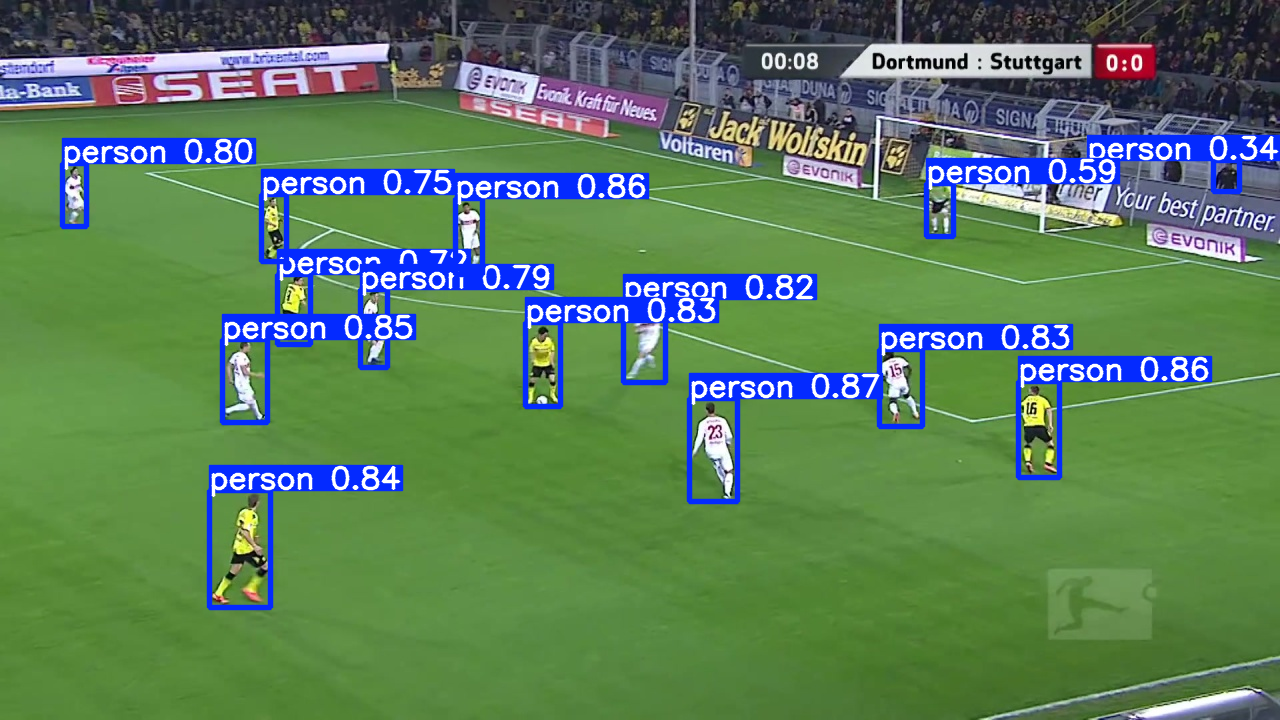

           xmin        ymin         xmax        ymax  confidence  class  \
0    689.628235  398.756104   737.210388  501.898865    0.867982      0   
1   1018.299561  381.986877  1059.773926  477.538757    0.862084      0   
2    455.574249  198.188568   482.779144  274.741791    0.861285      0   
3    222.617966  339.001984   267.982239  422.851776    0.848174      0   
4    209.008087  490.207275   270.415131  607.890747    0.839195      0   
5    525.510254  322.593750   560.333374  406.920349    0.832503      0   
6    879.515747  349.099915   922.291504  426.477844    0.827964      0   
7    623.146179  299.139709   665.705750  382.837952    0.817036      0   
8     62.978577  163.776443    86.821503  226.395554    0.796768      0   
9    360.440369  289.890350   387.034241  367.979889    0.789463      0   
10   261.114014  194.600815   286.006226  261.702850    0.752136      0   
11   277.088562  274.580261   310.532166  344.559814    0.715121      0   
12   926.369629  183.1480

In [4]:
import torch
import cv2
from matplotlib import pyplot as plt

# Step 2: Load YOLOv5 model (yolov5s is a small, pre-trained model)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.to("cpu")

# Step 3: Load an image
image_path = r"D:\Campus\CSE Life\S7\Advanced Machine Learning\Research Paper\Segment Anything\clips\test\img\v_1UDUODIBSsc_c001_000163.jpg"  # Change this to your image path
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Step 4: Inference
results = model(img_rgb)

# Step 5: Display results
results.show()  # Opens a window with detections
# or to save results: results.save()

# Optional: Print detected objects
print(results.pandas().xyxy[0])  # Bounding boxes with labels and confidence


Detected 83 masks!


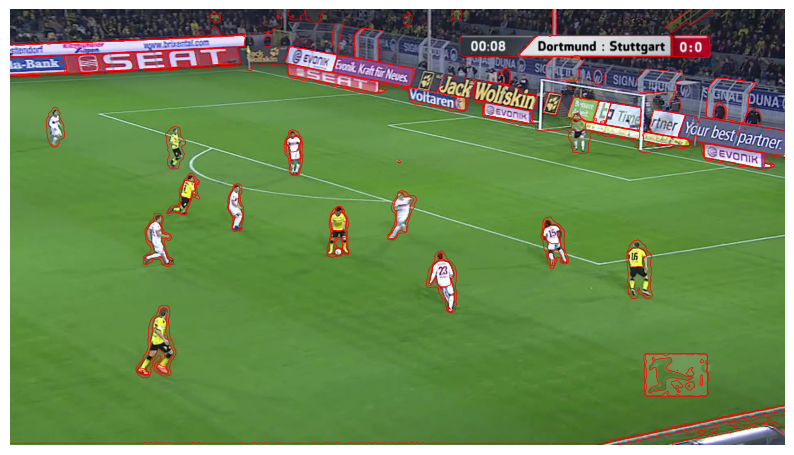

In [2]:
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import cv2
from matplotlib import pyplot as plt

# Step 2: Load SAM model
model_type = "vit_h"  # Options: vit_h (large), vit_l (large), vit_b (base)
sam_checkpoint = "../models/sam_vit_h_4b8939.pth"  # Download from official SAM repo

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cpu")

# Step 3: Load image
image_path = r"D:\Campus\CSE Life\S7\Advanced Machine Learning\Research Paper\Segment Anything\clips\test\img\v_1UDUODIBSsc_c001_000163.jpg"  # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 4: Initialize mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Step 5: Generate masks
masks = mask_generator.generate(image_rgb)

print(f"Detected {len(masks)} masks!")

# Step 6: Visualize masks
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
for mask_dict in masks:
    mask = mask_dict['segmentation']
    plt.contour(mask, colors='r', linewidths=0.5)  # Draw mask outline
plt.axis('off')
plt.show()

In [ ]:
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# YOLOv5
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model_yolo.to('cpu')

# SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
sam_checkpoint = "../models/sam_vit_h_4b8939.pth"  # Path to SAM checkpoint
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to('cpu')
mask_generator = SamAutomaticMaskGenerator(sam)

# Load image
image_path = r"D:\Campus\CSE Life\S7\Advanced Machine Learning\Research Paper\Segment Anything\clips\test\img\v_1UDUODIBSsc_c001_000163.jpg"  # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- Step 1: Detect humans with YOLOv5 ---
results = model_yolo(image_rgb)
humans = results.pandas().xyxy[0][results.pandas().xyxy[0]['class'] == 0]
print(f"Detected {len(humans)} humans")

# --------------------------
# Step 5: Run SAM on each human using box prompt (fast)
# --------------------------

predictor = SamPredictor(sam)   
predictor.set_image(image_rgb)
human_masks = []

for _, row in humans.iterrows():
    x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    crop = image_rgb[y1:y2, x1:x2]

    # SAM requires normalized box coordinates: [x0, y0, x1, y1] in pixels for crop
    box = np.array([0, 0, crop.shape[1], crop.shape[0]])

    # Predict mask using the box prompt
    masks, _, _ = predictor.predict(
        box=box,
        multimask_output=False      # Only one mask
    )

    human_masks.append(masks[0])

print(f"Generated {len(human_masks)} human masks with SAM (fast)")

# --------------------------
# Step 6: Visualize masks
# --------------------------
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
for mask in human_masks:
    plt.contour(mask, colors='r', linewidths=0.5)
plt.axis('off')
plt.show()

Using cache found in C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-9-23 Python-3.10.7 torch-2.8.0+cu126 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Detected 14 humans


ValueError: could not broadcast input array from shape (720,1280) into shape (103,48)